In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
%matplotlib inline
plt.viridis()

In [58]:
no_iterations = 3000000

# Wiring
n = 16
N = 1
S = (n, n)

s_max = 32
sigma_form_forward = 2.5
sigma_form_lateral = 1
p_form_lateral = 1
p_form_forward = 0.16
p_elim_dep = 0.0245
p_elim_pot = 1.36 * np.e ** -4
f_rew = 10 ** 4 * Hz#Hz

# Membrane
v_rest = -70 * mvolt #mV
e_ext = 0 * mvolt #V
v_thr = -54 * mvolt #mV
g_max = 0.2
tau_m = 20* ms #ms
tau_ex = 5* ms #ms
e = np.e
g = g_max
pre_t = 0 * ms


# Inputs
f_mean = 20 * Hz
f_base = 5 * Hz
f_peak = 152.8  * Hz
sigma_stim = 2
t_stim = 0.02 * second
rate = 200 * Hz

# STDP
Apre = a_plus = 0.1
b = 1.2
taupre = tau_plus = 20 * ms #ms
taupost = tau_minus = 64 * ms #ms
Apost = a_minus = (a_plus * tau_plus * b) / tau_minus

duration = 1000 * ms

In [64]:
import time
start = time.time() * second
start_scope()
projections = []
layers = []
neuron_dynamics = '''
dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
dgex/dt = -gex/tau_ex: 1
s : 1
'''
G = NeuronGroup(N, neuron_dynamics, threshold='v > -54 * mV',
                reset='v = -70 * mV', method='euler', dt=0.1 * ms, name="target_layer")
G.v   = [-70*mV,] * N
G.gex = [0.0, ]   * N
G.s   = [0, ]     * N
layers.append(G)
statemon = StateMonitor(G, ['v', 'gex'], record=True)
spikemon = SpikeMonitor(G)
ratemon  = PopulationRateMonitor(G)



# Pre pop
rate = f_base + f_peak * np.e ** (-0./(2 * sigma_stim**2))
inp = NeuronGroup(2, 'rates : Hz', threshold='rand()<rates*dt', dt=0.1 * ms, name="source_layer")
layers.append(inp)
inp.rates = rate

synapse_model = '''
                 w : 1
                 dapre/dt = -apre/taupre : 1 (event-driven)
                 dapost/dt = -apost/taupost : 1 (event-driven)
                 '''
on_pre_model = '''
                 gex_post += w
                 apre += Apre
                 w = clip(w+apost, 0, g_max)
                 '''
on_post_model = '''
                 apost += Apost
                 w = clip(w+apre, 0, g_max)
                 '''

# Feedforward connections (from source to target)
feedforward = Synapses(inp, G, synapse_model, 
                 on_pre = on_pre_model,
                 on_post = on_post_model,
                 dt = .1 * ms, name="feedforward_projections")
feedforward.connect()
feedforward.add_attribute('synapse_connected')
feedforward.synapse_connected = np.zeros(N**2, dtype=np.bool_)
# feedforward.w = [g_max, ] * (N**2)
feedforward.w = g_max
projections.append(feedforward)

# Lateral connections (from target to target)

lateral = Synapses(G, G, synapse_model, 
                 on_pre = on_pre_model,
                 on_post = on_post_model,
                 dt = .1 * ms, name="lateral_projections")
lateral.connect()
lateral.add_attribute('synapse_connected')
lateral.synapse_connected = np.zeros(N**2, dtype=np.bool_)
lateral.w = [0, ] * (N**2)
projections.append(lateral)

inp_spikemon = SpikeMonitor(inp)
inp_ratemon = PopulationRateMonitor(inp)

init_done = time.time() * second
print "Initialization done in ", init_done - start
print "Starting sim"    
run(duration)
print "Sim done"


end = time.time() * second
print "Simulation finished in", end - init_done

Initialization done in  125.99992752 ms
Starting sim


WARNING    "t" is an internal variable of group "feedforward_projections", but also exists in the run namespace with the value 0.9963 * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "lateral_projections", but also exists in the run namespace with the value 0.9963 * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Sim done
Simulation finished in 7.63999987 s


(0, 1000.0)

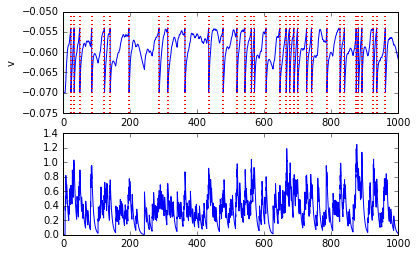

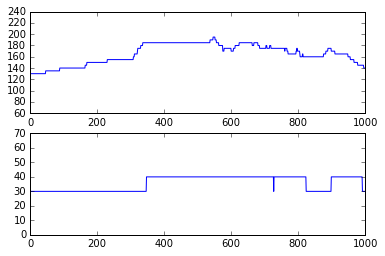

In [69]:
#     print "Output spike times:"
subplot(211)
plot(statemon.t/ms, statemon.v[0])
for t in spikemon.spike_trains()[0]:
    axvline(t/ms, ls=':', c='r', lw=2)
#         print t,
#     print "Input spike times:"
# for t in inp_spikemon.t:
#     axvline(t/ms, ls=':', c='y', lw=1)
#         print t,
xlabel('Time (ms)')
ylabel('v')
ylim([-.075, -.05])
subplot(212)
plot(statemon.t/ms, statemon.gex[0])

figure()
subplot(211)
plot(inp_ratemon.smooth_rate(window='flat', width=100 * ms) / Hz)
xlim(0, duration / ms)
subplot(212)
plot(ratemon.smooth_rate(window='flat', width=100 * ms) / Hz)
xlim(0, duration / ms)

In [66]:
print rate

157.8 Hz


In [67]:
print spikemon.num_spikes / duration

33. Hz


In [68]:
print np.mean(ratemon.smooth_rate(window='flat', width=duration))

24.44980979 Hz


In [71]:
_wat = []
for i in range(int(duration/ms)):
    _wat.append(np.mean(ratemon.smooth_rate(window='flat', width=i * ms)))

INFO       width adjusted from 0. s to 100. us [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 1. ms to 1.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 2. ms to 2.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 3. ms to 3.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 4. ms to 4.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 5. ms to 5.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 6. ms to 6.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 7. ms to 7.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 8. ms to 8.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 9. ms to 9.1 ms [brian2.monitors.ratemonitor.adjusted_width]
INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.ad

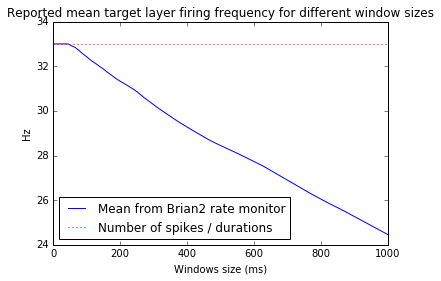

In [78]:
plot(_wat, label="Mean from Brian2 rate monitor")
plot([spikemon.num_spikes / duration,]*len(_wat), ':r', label="Number of spikes / durations")
xlabel('Windows size (ms)')
ylabel('Hz')
title('Reported mean target layer firing frequency for different window sizes')
legend(loc='best')

In [79]:
1./ rate

6.33713561 * msecond